In [3]:
# !pip install transformers==4.50.3 datasets evaluate sacrebleu bert_score rouge_score

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [3]:
import pandas
import seaborn
import numpy
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from datasets import Dataset
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plot
from nltk.tokenize import sent_tokenize
from evaluate import load
import sacrebleu
from bert_score import score
from bert_score import score as bert_score
import nltk
from datasets import DatasetDict
import re

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abhilash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Abhilash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# Load dataset

retailSupplyChainData = pandas.read_csv('./DataCoSupplyChainDataset.csv', encoding='ISO-8859-1')
retailSupplyChainDataFrame = pandas.DataFrame(retailSupplyChainData) # extracting the data

print(retailSupplyChainDataFrame.info())
print(retailSupplyChainDataFrame.describe())

print(retailSupplyChainDataFrame.head())

# Checking null values
retailSupplyChainDataFrame.isnull().sum()

retailSupplyChainDataFrame.drop(columns = ['Order Zipcode', 'Order Customer Id', 'Order Item Id', 'Order Item Id', 'Order Item Cardprod Id', 'Product Description', 'Customer Id', 'Customer Fname', 'Customer Email', 'Customer Lname', 'Customer Password', 'Customer Street', 'Customer Zipcode', 'Latitude', 'Longitude', 'Product Image', 'Product Status'], inplace = True)

# Rename columns
retailSupplyChainDataFrame.rename(columns={
    'order date (DateOrders)': 'Order Date',
    'shipping date (DateOrders)': 'Shipping Date',
    'Days for shipment (scheduled)': 'Days for shipment Scheduled',
    'Days for shipping (real)': 'Days for shipping real'
}, inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [5]:
# Convert date columns to datetime format
retailSupplyChainDataFrame['Order Date'] = pandas.to_datetime(retailSupplyChainDataFrame['Order Date'], format='%m/%d/%Y %H:%M')
retailSupplyChainDataFrame['Shipping Date'] = pandas.to_datetime(retailSupplyChainDataFrame['Shipping Date'], format='%m/%d/%Y %H:%M')

retailSupplyChainDataFrame = retailSupplyChainDataFrame.sort_values(by='Order Date')

# Feature Engineering- Create time-based features
retailSupplyChainDataFrame['Year'] = retailSupplyChainDataFrame['Order Date'].dt.year
retailSupplyChainDataFrame['Month'] = retailSupplyChainDataFrame['Order Date'].dt.month
retailSupplyChainDataFrame['Day'] = retailSupplyChainDataFrame['Order Date'].dt.day
retailSupplyChainDataFrame['Weekday'] = retailSupplyChainDataFrame['Order Date'].dt.weekday

retailSupplyChainDataFrame.set_index('Order Date', inplace=True)

# Introducing LAGs
retailSupplyChainDataFrame['lag_1'] = retailSupplyChainDataFrame['Sales'].shift(1)
retailSupplyChainDataFrame['rolling_mean'] = retailSupplyChainDataFrame['Sales'].rolling(window=7).mean()
retailSupplyChainDataFrame['rolling_std'] = retailSupplyChainDataFrame['Sales'].rolling(window=7).std()

# Handle missing values
retailSupplyChainDataFrame.dropna(inplace=True)
retailSupplyChainDataFrame.isnull().sum()

# Interpolate missing values
retailSupplyChainDataFrame.interpolate(method='linear', inplace=True)

C:\Users\Abhilash\AppData\Local\Temp\ipykernel_16780\1670792112.py:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  retailSupplyChainDataFrame.interpolate(method='linear', inplace=True)


In [6]:
# Remove outliers
integerColumns = retailSupplyChainDataFrame.select_dtypes(include= numpy.number).columns

for i in integerColumns:
    column = retailSupplyChainDataFrame[i]

    # Calculate IQR for each column
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Define boundaries
    lowerBoundary = Q1 - 1.5 * IQR
    upperBoundary = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = retailSupplyChainDataFrame[(column < lowerBoundary) | (column > upperBoundary)]

    #Impute Outliers with median
    retailSupplyChainDataFrame = retailSupplyChainDataFrame[(retailSupplyChainDataFrame[i] >= lowerBoundary) & (retailSupplyChainDataFrame[i] <= upperBoundary)]


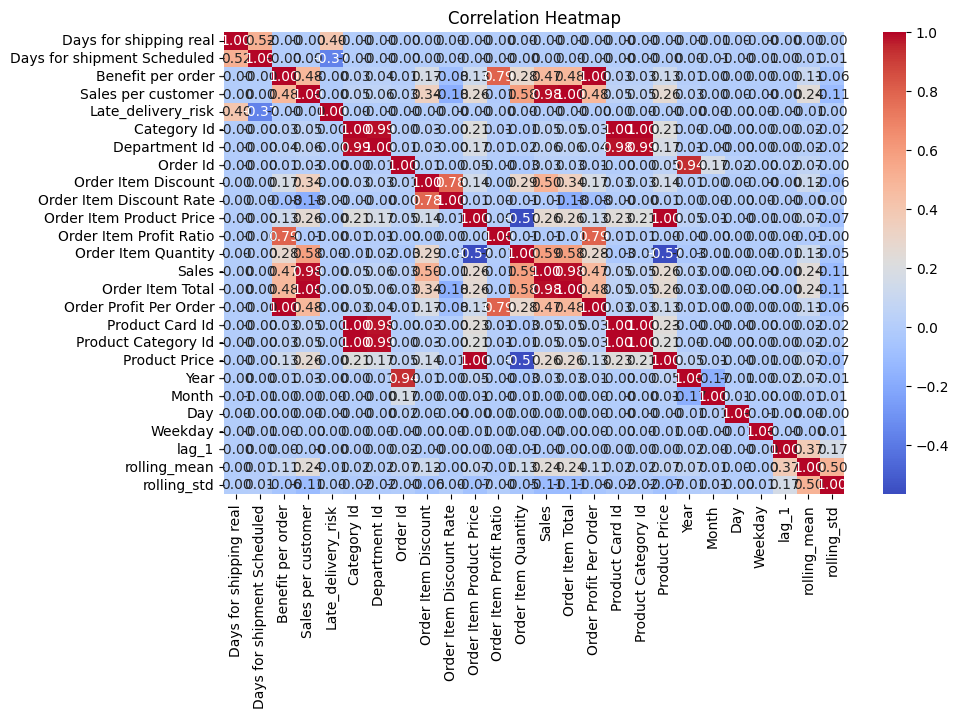

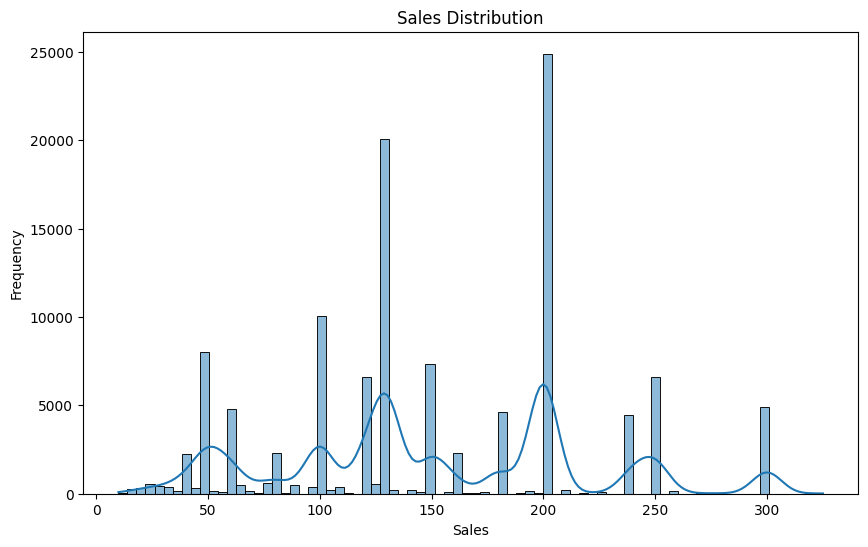

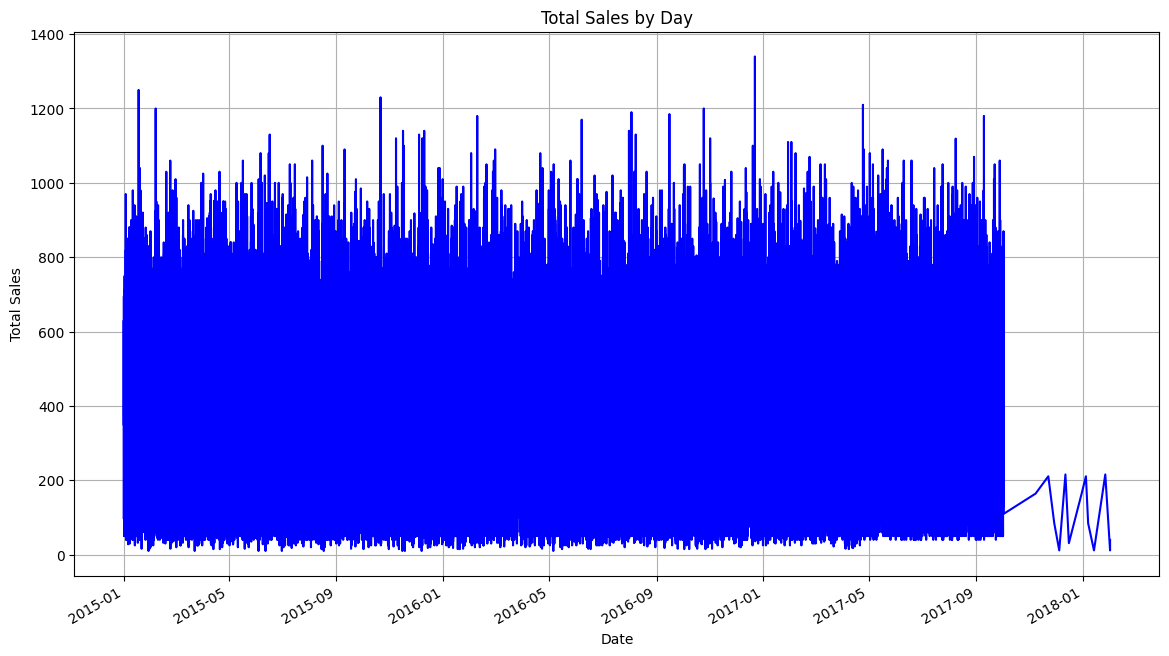

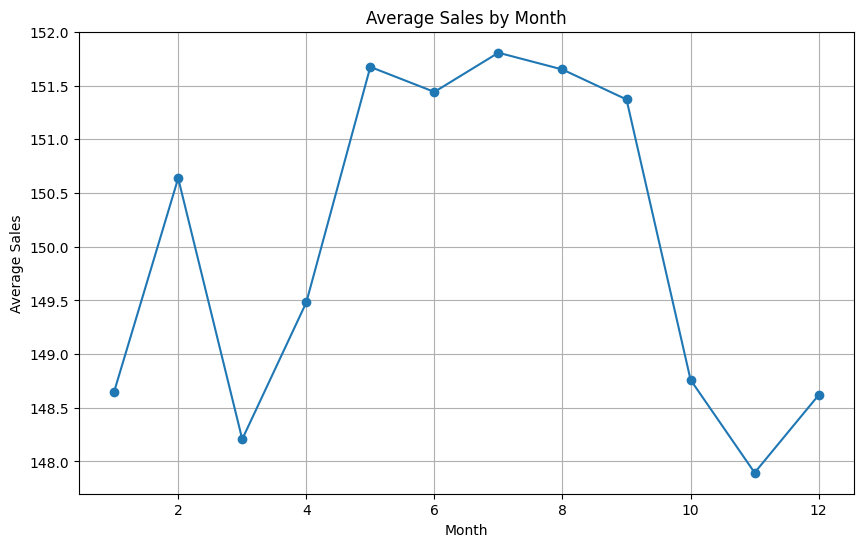

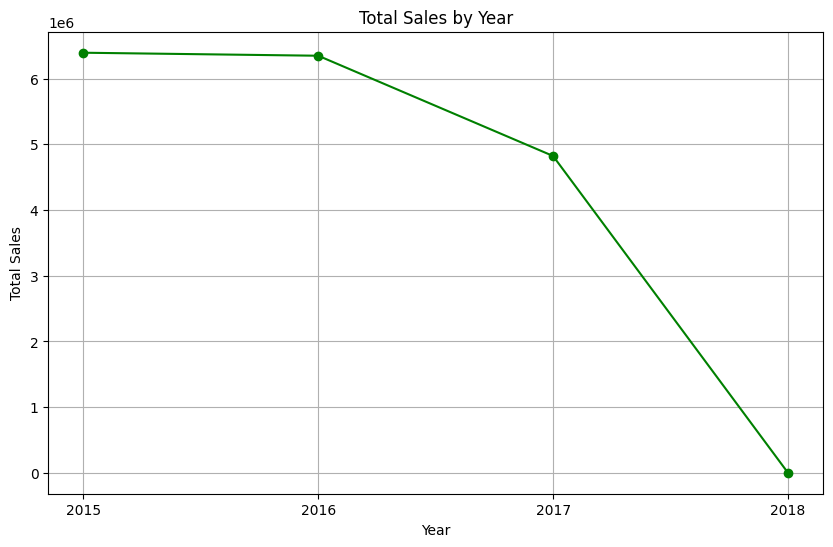

In [7]:
# Exploratory Data Analysis (EDA)

# Heatmap for Correlations
plot.figure(figsize=(10, 6))
seaborn.heatmap(retailSupplyChainDataFrame[integerColumns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plot.title("Correlation Heatmap")
plot.show()


# Histogram of sales
plot.figure(figsize=(10, 6))
seaborn.histplot(retailSupplyChainDataFrame['Sales'], kde=True)
plot.title('Sales Distribution')
plot.xlabel('Sales')
plot.ylabel('Frequency')
plot.show()


# Sales by day
dailySales = retailSupplyChainDataFrame.groupby('Order Date')['Sales'].sum()

plot.figure(figsize=(14, 8))
dailySales.plot(kind='line', color='blue')
plot.title('Total Sales by Day')
plot.xlabel('Date')
plot.ylabel('Total Sales')
plot.grid(True)
plot.show()

#Sales by month
monthlySales = retailSupplyChainDataFrame.groupby('Month')['Sales'].mean()

plot.figure(figsize=(10, 6))
monthlySales.plot(kind='line', marker='o')
plot.title('Average Sales by Month')
plot.xlabel('Month')
plot.ylabel('Average Sales')
plot.grid(True)
plot.show()

# Sales by year (total sales)
yearlySales = retailSupplyChainDataFrame.groupby('Year')['Sales'].sum()

plot.figure(figsize=(10, 6))
yearlySales.plot(kind='line', marker='o', color='green')
plot.title('Total Sales by Year')
plot.xlabel('Year')
plot.ylabel('Total Sales')
plot.xticks(yearlySales.index)
plot.grid(True)
plot.show()

In [ ]:
retailSupplyChainDataFrame.drop(columns=['Shipping Date'], inplace=True)

In [9]:
# Resample to daily sales
retailSupplyChainDataFrame = retailSupplyChainDataFrame[['Sales']].resample('D').sum()
# retailSupplyChainDataFrame['Sales'].fillna(0, inplace=True)
retailSupplyChainDataFrame.fillna({'Sales': 0}, inplace=True)

In [10]:
# Create sequences for BART
input_window = 30
forecast_horizon = 90

def create_sequences(data, input_len=30, output_len=90):
    inputs, targets = [], []
    for i in range(len(data) - input_len - output_len):
        input_seq = data[i:i + input_len]
        target_seq = data[i + input_len:i + input_len + output_len]
        inputs.append(" ".join([f"{x:.2f}" for x in input_seq]))
        targets.append(" ".join([f"{x:.2f}" for x in target_seq]))
    return inputs, targets

input_seqs, target_seqs = create_sequences(retailSupplyChainDataFrame['Sales'].values, input_window, forecast_horizon)

# Tokenize
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

def tokenize(example):
    model_input = tokenizer(example['input'], truncation=True, padding="max_length", max_length=128)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example['target'], truncation=True, padding="max_length", max_length=384)
    model_input["labels"] = labels["input_ids"]
    return model_input

dataset = Dataset.from_dict({"input": input_seqs, "target": target_seqs})
tokenized_dataset = dataset.map(tokenize, batched=False)

# Train-test split
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% temp
val_test_split = split_dataset['test'].train_test_split(test_size=0.5, seed=42)  # 10% val, 10% test

# Combine into a DatasetDict
dataset_dict = DatasetDict({
    'train': split_dataset['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})

tokenized_datasets = dataset_dict.map(tokenize, batched=False)

# Extract
trainDataset = tokenized_datasets['train']
valDataset = tokenized_datasets['validation']
testDataset = tokenized_datasets['test']



Map:   0%|          | 0/1007 [00:00<?, ? examples/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 101/101 [00:00<00:00, 1037.22 examples/s]


In [11]:
# Load model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)

iterations = 10
lr = 3e-5
weightDecay = 0.01
batchSize = 4

# Training args
training_args = Seq2SeqTrainingArguments(
    output_dir="./sales_forecast",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=batchSize,
    per_device_eval_batch_size=batchSize,
    weight_decay=weightDecay,
    save_total_limit=iterations,
    num_train_epochs=iterations,
    predict_with_generate=True,
    logging_dir="./logs_sales_forecast",
    fp16=False,
    fp16_opt_level='O0',
    use_mps_device=True,
    use_cpu=False,
    generation_max_length=256,
    generation_num_beams=4
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:2290: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Metrics functions
rouge = load("rouge")

def decodeTokens(tokens):
    # Handle potential None values in tokens
    valid_tokens = [[token for token in seq if token is not None] for seq in tokens]  # Filter out None values
    # Ensure all elements in valid_tokens are lists
    valid_tokens = [seq if isinstance(seq, list) else [seq] for seq in valid_tokens]
    return tokenizer.batch_decode(valid_tokens, skip_special_tokens=True)

def cleanTokenize(decodedTexts):
    return ["\n".join(sent_tokenize(text.strip())) for text in decodedTexts]

def computeRouge(predictions, labels):
    result = rouge.compute(predictions=predictions, references=labels)
    return {f"rouge_{k}": v * 100 for k, v in result.items()}

def computeBleu(predictions, labels):
    score_bleu = sacrebleu.corpus_bleu(predictions, [labels])
    return {"bleu": score_bleu.score}

def computeBertScore(predictions, labels):
    P, R, F1 = score(predictions, labels, lang="en", verbose=False)
    return {
        "bertscore_precision": P.mean().item() * 100,
        "bertscore_recall": R.mean().item() * 100,
        "bertscore_f1": F1.mean().item() * 100
    }

def getMetrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = decodeTokens(predictions)
    decoded_labels = decodeTokens(labels)
    cleaned_preds = cleanTokenize(decoded_preds)
    cleaned_labels = cleanTokenize(decoded_labels)
    return {
        **computeRouge(cleaned_preds, cleaned_labels),
        **computeBleu(cleaned_preds, cleaned_labels),
        **computeBertScore(cleaned_preds, cleaned_labels)
    }

In [13]:
# Trainer
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=trainDataset,
    eval_dataset=valDataset,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=getMetrics
)

# Train the model
trainer.train()

/var/folders/y1/4ydmkr1n7f72dsyswnh_jqwc0000gn/T/ipykernel_29419/3978544347.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge Rouge1,Rouge Rouge2,Rouge Rougel,Rouge Rougelsum,Bleu,Bertscore Precision,Bertscore Recall,Bertscore F1
1,3.165100,2.525805,14.580842,0.173561,7.451143,7.452682,0.007879,83.868426,83.938402,83.901322
2,2.029200,0.694215,26.958428,6.630908,13.315423,13.279337,2.626476,89.523375,88.588411,89.052331
3,0.864800,0.117164,31.481336,14.773800,20.431417,20.521751,11.035752,90.235811,89.272261,89.747769
4,0.339200,0.052410,29.467560,11.364064,16.963782,17.050590,8.721510,90.358418,89.252156,89.798266
5,0.170200,0.044298,25.042711,5.271272,12.365264,12.188610,4.257195,89.760232,88.888526,89.320093
6,0.105300,0.045393,26.973546,8.444637,14.762084,14.764328,6.357947,89.931607,89.065206,89.492768
7,0.081300,0.038360,27.002485,7.492061,14.513450,14.311031,5.902525,89.815313,89.084965,89.445901
8,0.067700,0.035152,36.338495,21.170930,26.791967,26.860294,16.182542,90.732878,89.671385,90.195549
9,0.061100,0.036200,32.669311,16.062425,21.559339,21.553565,12.639639,90.596282,89.473867,90.027696
10,0.057900,0.034933,32.562661,16.032489,21.315065,21.242721,12.421230,90.501887,89.470303,89.980084


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Some

TrainOutput(global_step=2020, training_loss=0.6941889743993778, metrics={'train_runtime': 3616.7555, 'train_samples_per_second': 2.226, 'train_steps_per_second': 0.559, 'total_flos': 613547311104000.0, 'train_loss': 0.6941889743993778, 'epoch': 10.0})

In [14]:
# saving the model

trainer.save_model("./sales_forecast")
tokenizer.save_pretrained("./sales_forecast")

('./sales_forecast/tokenizer_config.json',
 './sales_forecast/special_tokens_map.json',
 './sales_forecast/vocab.json',
 './sales_forecast/merges.txt',
 './sales_forecast/added_tokens.json')

In [31]:
from torchinfo import summary

summary(model, input_size=(1, 1024), dtypes=[torch.long])  # input size for BART token IDs


Layer (type:depth-idx)                                  Output Shape              Param #
BartForConditionalGeneration                            [1, 1024, 768]            --
├─BartModel: 1-1                                        [1, 1024, 768]            --
│    └─BartEncoder: 2-1                                 [1, 1024, 768]            --
│    │    └─BartScaledWordEmbedding: 3-1                [1, 1024, 768]            38,603,520
│    │    └─BartLearnedPositionalEmbedding: 3-2         [1, 1024, 768]            787,968
│    │    └─LayerNorm: 3-3                              [1, 1024, 768]            1,536
│    │    └─ModuleList: 3-4                             --                        42,527,232
│    └─BartDecoder: 2-2                                 [1, 12, 1024, 64]         --
│    │    └─BartScaledWordEmbedding: 3-5                [1, 1024, 768]            38,603,520
│    │    └─BartLearnedPositionalEmbedding: 3-6         [1, 1024, 768]            787,968
│    │    └─LayerNorm: 

In [16]:
# Predict
predictions = trainer.predict(testDataset)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
decodedPredictions = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
decodedLabels = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

cleanedPredictionsStr = ["\n".join(sent_tokenize(prediction)) for prediction in decodedPredictions]
cleanedLabelsStr = ["\n".join(sent_tokenize(label)) for label in decodedLabels]

# Clean up predictions
cleanedPredictions = []
for pred in decodedPredictions:
    pred = pred.strip().replace('  ', ' ')  # Remove extra spaces
    pred = pred.replace("\n", " ")  # Replace newline characters with a space

    # Split by non-numeric characters but keep decimal points intact
    numbers = re.findall(r'\d+\.\d+|\d+', pred)  # This will match both floats and integers

    # Convert to floats (handle comma as dot)
    numbers = [float(x.replace(',', '.')) for x in numbers if x]  # Replace commas with dots and convert to floats

    # Only keep the first 90 values (to match forecast horizon)
    numbers = numbers[:90]

    # If less than 90 values, pad the list with the last value
    if len(numbers) < 90:
        numbers += [numbers[-1]] * (90 - len(numbers))  # Pad if too short

    cleanedPredictions.append(numbers)

# Similarly for targets
actuals = [seq['target'] for seq in testDataset]
cleanedTargets = []
for tgt in actuals:
    tgt = tgt.strip().replace('  ', ' ')  # Remove extra spaces
    numbers = re.findall(r'\d+\.\d+|\d+', tgt)  # This will match both floats and integers
    numbers = [float(x.replace(',', '.')) for x in numbers if x]  # Replace commas with dots and convert to floats
    numbers = numbers[:90]  # Only keep the first 90 values
    cleanedTargets.append(numbers)


In [23]:
rougeScores = rouge.compute(predictions=cleanedPredictionsStr, references=cleanedLabelsStr)
print(f"\nROUGE scores:")
for key, val in rougeScores.items():
    print(f"{key}: {val * 100:.2f}")

# Compute BLEU
bleu = sacrebleu.corpus_bleu(cleanedPredictionsStr, [cleanedLabelsStr])
print(f"\nBLEU Score: {bleu.score:.2f}")

# Compute BERTScore
P, R, F1 = bert_score(cleanedPredictionsStr, cleanedLabelsStr, lang="en", verbose=False)
print(f"\nBERT Scores:")
print(f"Precision:{P.mean()*100:.2f}")
print(f"Recall:{R.mean()*100:.2f}")
print(f"F1:{F1.mean()*100:.2f}")


ROUGE scores:
rouge1: 39.93
rouge2: 26.13
rougeL: 30.31
rougeLsum: 30.24

BLEU Score: 20.18


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERT Scores:
Precision:91.31
Recall:90.15
F1:90.73


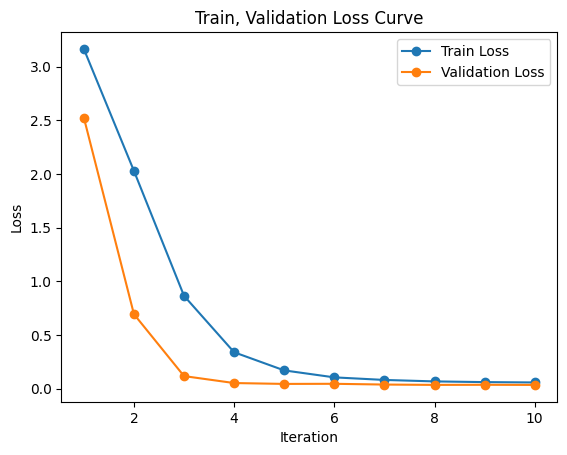

In [ ]:
# Plot Training and Validation Loss
logs = trainer.state.log_history
trainLoss = [x["loss"] for x in logs if "loss" in x and "eval_loss" not in x]
valLoss = [x["eval_loss"] for x in logs if "eval_loss" in x]
epochs = [x["epoch"] for x in logs if "eval_loss" in x]

plot.plot(epochs, trainLoss, marker='o', label="Train Loss")
plot.plot(epochs, valLoss, marker='o', label="Validation Loss")
plot.title("Train, Validation Loss Curve")
plot.xlabel("Iteration")
plot.ylabel("Loss")
plot.legend()
plot.show()

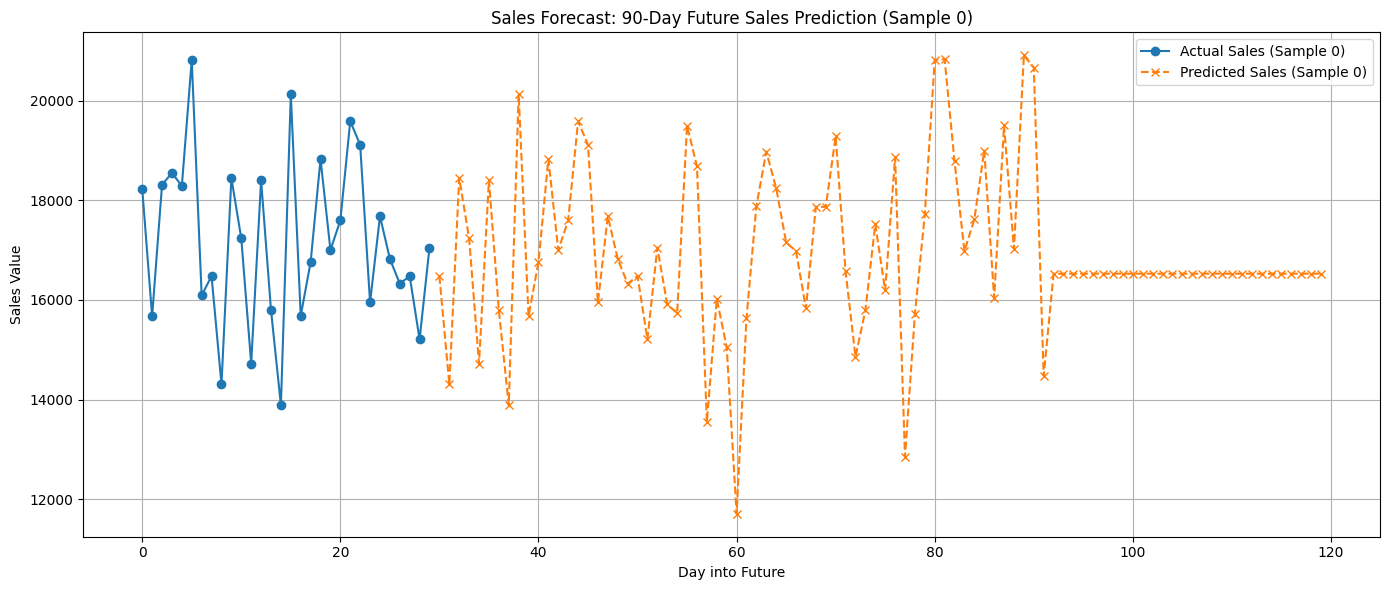

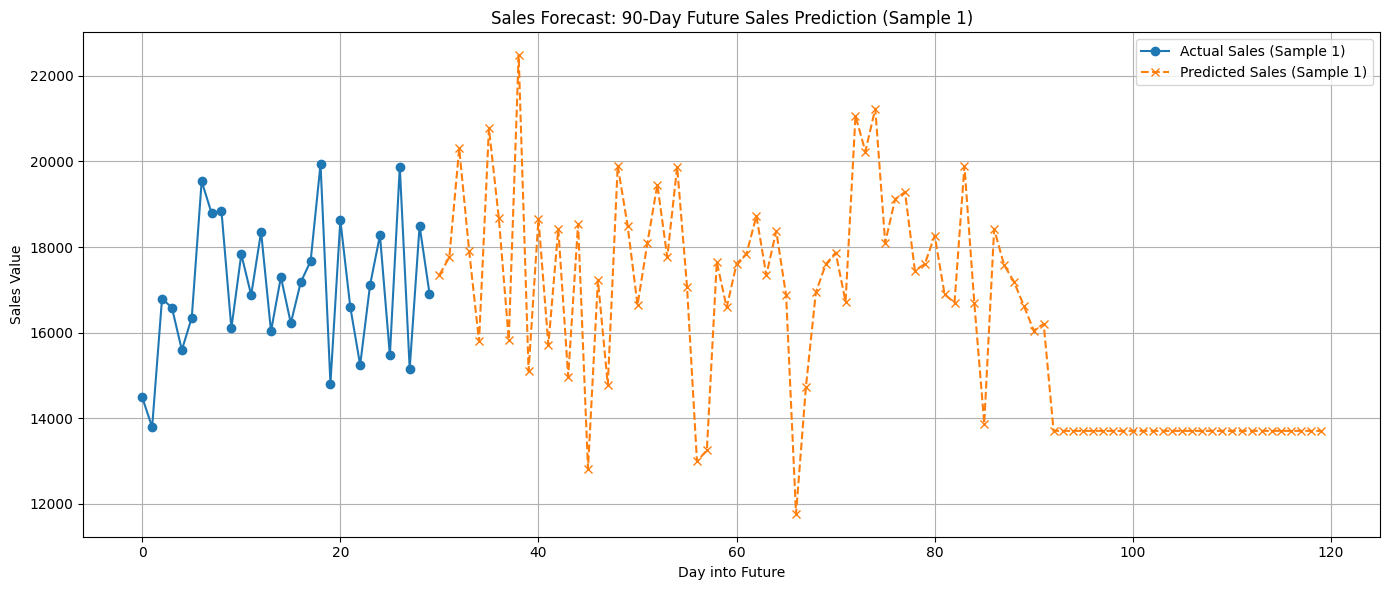

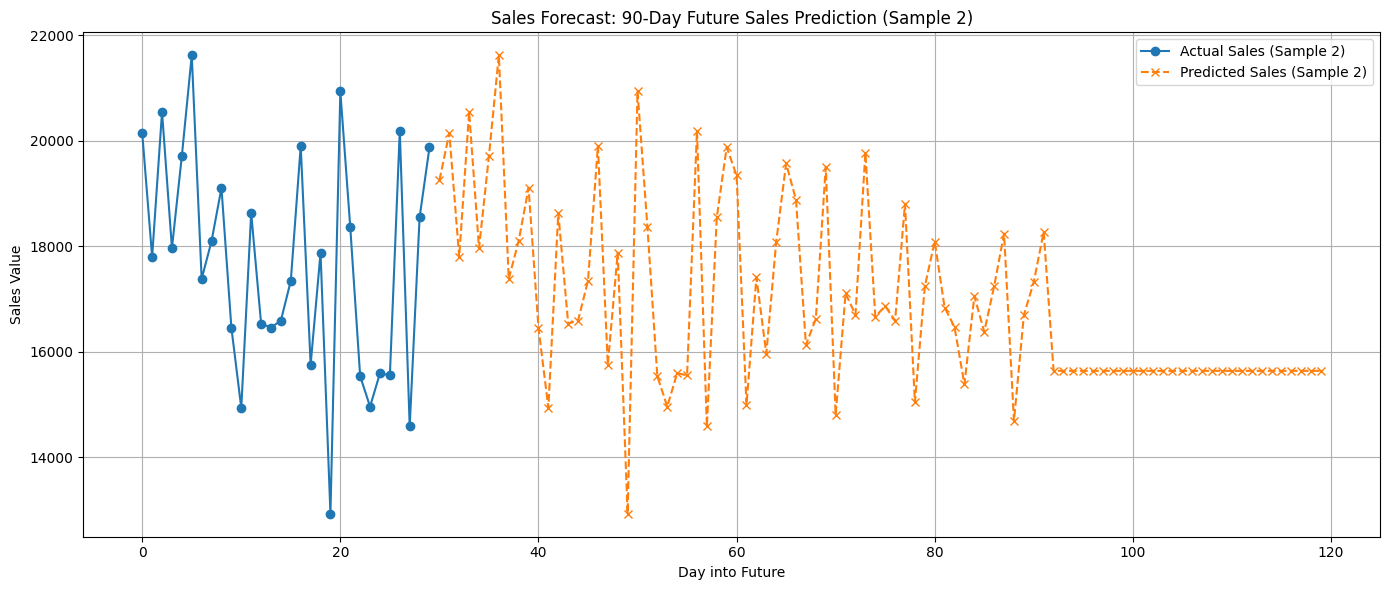

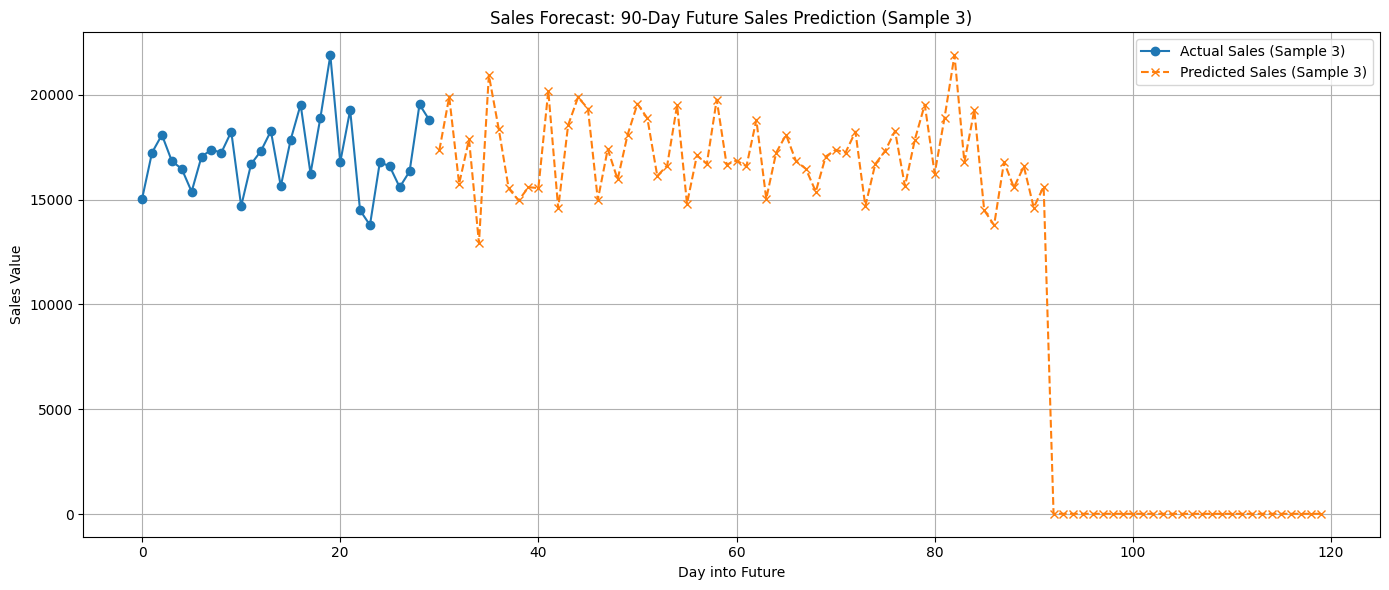

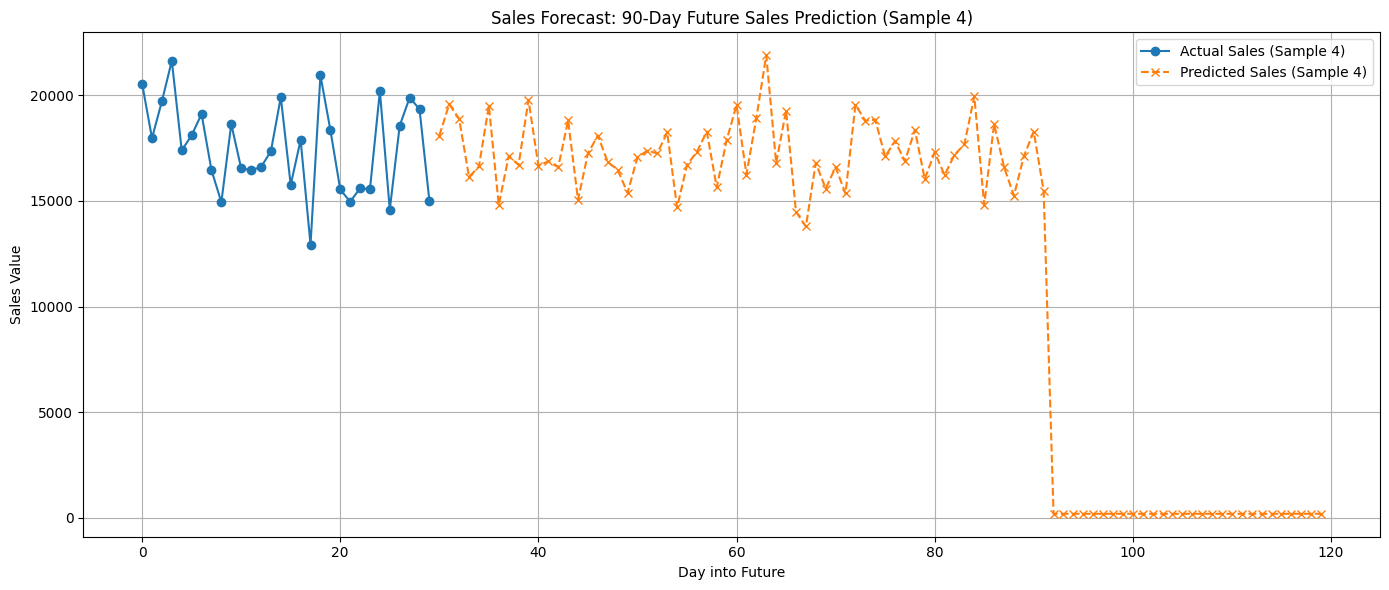

In [ ]:
# Plot sales forecasting

for i in range(5):  # Loop through 5 samples for plotting
    plot.figure(figsize=(14, 6))

    # Plot historical (last 30 days) sales values
    historical_sales = cleanedTargets[i][:30]  # cleanedTargets[i] contains historical data as well
    plot.plot(range(len(historical_sales)), historical_sales, label=f'Actual Sales (Sample {i})', marker='o')

    # Plot predicted (next 90 days) sales values
    predicted_sales = cleanedPredictions[i]  # These are the predicted values for the next 90 days
    plot.plot(range(len(historical_sales), len(historical_sales) + len(predicted_sales)), predicted_sales,
             label=f'Predicted Sales (Sample {i})', linestyle='dashed', marker='x')

    plot.title(f"Sales Forecast: 90-Day Future Sales Prediction (Sample {i})")
    plot.xlabel("Day into Future")
    plot.ylabel("Sales Value")
    plot.legend()
    plot.grid(True)
    plot.tight_layout()
    plot.show()


In [27]:
retailSupplyChainDataFrame.to_csv('daily_sales.csv')